In [1]:
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt
import seaborn as sns

integration_method = 'exponential_euler'

In [2]:
def F(i, taum, tarp=0*ms):
    if np.isscalar(i):
        if i <= 1:
            return 0*Hz
        return 1 / (tarp + taum*(np.log(i)-np.log(i-1)))
    nu = np.zeros_like(i) * Hz
    idx = i > 1
    nu[idx] = 1 / (tarp + taum*(np.log(i[idx])-np.log(i[idx]-1)))
    return nu

In [3]:
# neuron parameters
taum = 20*ms
tarp = 2*ms

# how many neurons
N_pre = 1000
N_post = 10000

# synaptic parameters
taus = 5*ms
nu_pre = 5*Hz
J = 0.05

In [4]:
i_syn_mean = (N_pre * nu_pre * J * taus)
F_mean = F(i_syn_mean, taum, tarp)
print('Mean synaptic current: {:g}.'.format(i_syn_mean))
print('Firing rate: {:g} spikes/s.'.format(F_mean))

Mean synaptic current: 1.25.
Firing rate: 29.2494 spikes/s.


In [5]:
neuron_eqs = Equations("""
du/dt = (-u+i_syn)/taum : 1 (unless refractory)
di_syn/dt = -i_syn/taus : 1
""")
thresh_cond = 'u>1'
reset_action= 'u=0'

In [6]:
neurons = NeuronGroup(N_post, neuron_eqs, threshold=thresh_cond, reset=reset_action,
                      refractory=tarp, method=integration_method, name='neuron')
neurons.u = 0

In [7]:
poisson_pre = PoissonInput(neurons, 'i_syn', N_pre, nu_pre, J)

In [8]:
post_spike_mon = SpikeMonitor(neurons)
state_mon = StateMonitor(neurons, ['u','i_syn'], record=True)

In [9]:
tend = 500*ms
run(tend)

In [10]:
t = state_mon.t/ms
u = state_mon.u[0]
isyn = state_mon.i_syn[0]

In [11]:
spike_times = post_spike_mon.t/ms
bin_size = taus/ms
edges = np.r_[0 : t[-1] : bin_size]
n,_ = np.histogram(spike_times, edges)
firing_rate = n/N_post/(bin_size*1e-3)

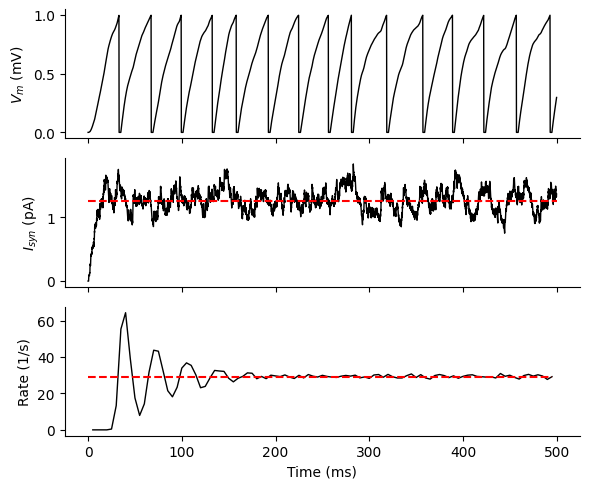

In [12]:
rows = 3 if N_post > 1 else 2
fig,ax = plt.subplots(rows, 1, figsize=(6,rows+2), sharex=True)
ax[0].plot(t, u, 'k', lw=1)
ax[1].plot(t, isyn, 'k', lw=1)
ax[1].plot(t[[0,-1]], i_syn_mean+np.zeros(2), 'r--')
ax[0].set_ylabel(r'$V_m$ (mV)')
ax[1].set_ylabel(r'$I_{syn}$ (pA)')
if rows > 2:
    ax[2].plot(edges[1:], firing_rate, 'k', lw=1)
    ax[2].plot(edges[[0,-1]], F_mean+np.zeros(2), 'r--')
    ax[2].set_ylabel('Rate (1/s)')
ax[-1].set_xlabel('Time (ms)')
sns.despine()
fig.tight_layout()
plt.savefig('feedforward_net.png')